# Housing Price Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import house_imputing as imp
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
prices = pd.read_csv('../data/Ames_Housing_Price_Data.csv',index_col = 0)
latlon = pd.read_csv('../data/full_latlon.csv')

In [2]:
prices.reset_index(drop = True, inplace = True)
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

LotFrontage      462
Alley           2412
MasVnrType        14
MasVnrArea        14
BsmtQual          69
BsmtCond          69
BsmtExposure      71
BsmtFinType1      69
BsmtFinType2      70
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1241
GarageType       127
GarageYrBlt      129
GarageFinish     129
GarageQual       129
GarageCond       129
PoolQC          2571
Fence           2055
MiscFeature     2483
dtype: int64

In [3]:
#Merge housing data with coordinate data
prices = pd.merge(prices, latlon, how='left', left_on = 'PID', right_on = 'PID' )
prices.drop('coord',axis = 1,inplace = True)

In [4]:
#Exclude neighborhoods outside the Ames, IA city limits
prices = prices.drop_duplicates()
prices = prices.loc[~prices['Neighborhood'].isin(['Landmrk','Greens','GrnHill'])]

### Convert distances from km to miles

In [5]:
prices[['dist_airport','dist_downtown','dist_stadium']] = prices[['dist_airport','dist_downtown',
                                                                 'dist_stadium']].apply(lambda D: D*0.621371)

In [6]:
#Impute the following missing values with the mode
prices['MasVnrType'].fillna(prices['MasVnrType'].mode()[0],inplace = True)
prices['MasVnrArea'].fillna(prices['MasVnrArea'].mode()[0],inplace = True)
prices['Electrical'].fillna(prices['Electrical'].mode()[0],inplace = True)

In [7]:
#Creating a price per square foot column to help with feature engineering
prices['Price_sqft'] = prices['SalePrice']/prices['GrLivArea']

#Create copy for tree-based models
tree_prices = prices.copy()

# Converting quality/condition categoricals to numerical

In [8]:
prices['KitchenQual'] = imp.ordinal_scale(prices['KitchenQual'])
prices['ExterQual'] = imp.ordinal_scale(prices['ExterQual'])
prices['ExterCond'] = imp.ordinal_scale(prices['ExterCond'])
prices['HeatingQC'] = imp.ordinal_scale(prices['HeatingQC'])

In [9]:
impute_cols = ['Alley','BsmtExposure','BsmtFinType1',
               'BsmtFinType2','Fence','GarageType']
ordinal_cols = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual',
                'GarageCond','PoolQC','GarageFinish']

for i in impute_cols:
    prices[i] = imp.fillna_cats(prices[i])
    tree_prices[i] =  imp.fillna_cats(tree_prices[i])

for j in ordinal_cols:
    prices[j] = imp.fillna_cats(prices[j])
    tree_prices[j] = imp.fillna_cats(tree_prices[j])

In [10]:
tree_prices['MiscFeature'] = imp.fillna_cats(tree_prices['MiscFeature'])
tree_prices['LotFrontage'] = imp.impute_by_neighborhood(tree_prices,'LotFrontage','mean')
tree_prices['GarageYrBlt'] = imp.impute_by_neighborhood(tree_prices,'GarageYrBlt','median')


prices['LotFrontage'] = imp.impute_by_neighborhood(prices,'LotFrontage','mean')
prices['GarageYrBlt'] = imp.impute_by_neighborhood(prices,'GarageYrBlt','median')


#fill remaining missing columns with the column mean
tree_prices = tree_prices.fillna(tree_prices.mean())

tree_nulls = tree_prices.isnull().sum()
tree_nulls[tree_nulls>1]

Series([], dtype: int64)

## Convert columns to numerical for linear regression

In [11]:
for i in ordinal_cols:
    prices[i].replace({'Po':0,'DNE':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace = True)
    
prices['MiscFeature'].fillna(0,inplace = True)
prices['GarageFinish'] = prices['GarageFinish'].replace({'DNE':1, 'Unf':2, 'RFn':3, 'Fin':4})
prices['MiscFeature'] = prices['MiscFeature'].apply(lambda M: 1 if M !=0 else M)
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)
prices['Street'].replace({'Grvl':0,'Pave':1},inplace = True)
prices['PavedDrive'].replace({'Y':1,'P':0.5,'N':0},inplace = True)
prices['Utilities'].replace({'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1},inplace = True)    

In [12]:
prices = prices.fillna(prices.mean())
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

Series([], dtype: int64)

### Differences in neighborhood development

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'SWISU'),
  Text(1, 0, 'Edwards'),
  Text(2, 0, 'IDOTRR'),
  Text(3, 0, 'OldTown'),
  Text(4, 0, 'NWAmes'),
  Text(5, 0, 'Blmngtn'),
  Text(6, 0, 'Mitchel'),
  Text(7, 0, 'NridgHt'),
  Text(8, 0, 'NAmes'),
  Text(9, 0, 'CollgCr'),
  Text(10, 0, 'SawyerW'),
  Text(11, 0, 'MeadowV'),
  Text(12, 0, 'BrDale'),
  Text(13, 0, 'Gilbert'),
  Text(14, 0, 'Timber'),
  Text(15, 0, 'Somerst'),
  Text(16, 0, 'BrkSide'),
  Text(17, 0, 'NoRidge'),
  Text(18, 0, 'Sawyer'),
  Text(19, 0, 'Crawfor'),
  Text(20, 0, 'ClearCr'),
  Text(21, 0, 'StoneBr'),
  Text(22, 0, 'Veenker'),
  Text(23, 0, 'NPkVill'),
  Text(24, 0, 'Blueste')])

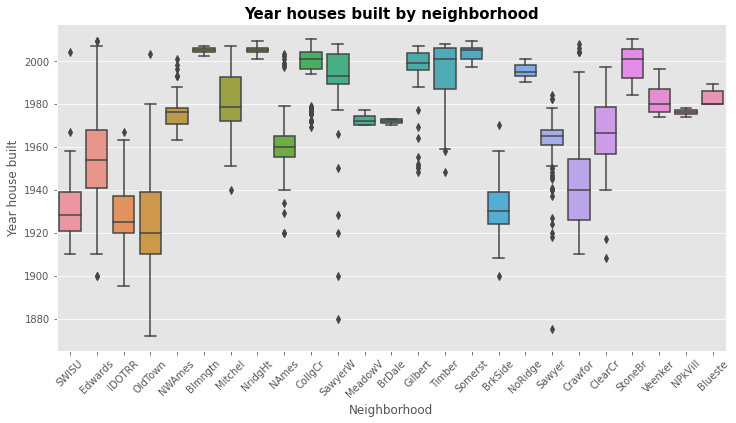

In [13]:
plt.figure(figsize = (12,6))
plt.title('Year houses built by neighborhood', fontsize = 15, fontweight = 'bold')
sns.boxplot(data = prices, x = 'Neighborhood', y = 'YearBuilt')
plt.ylabel('Year house built')
plt.xticks(rotation = 45,labels=None)

<p>Imputing certain columns by neighborhood works better for time series data than simply using a measure from the entire dataset.</p>

# Selecting numerical variables for multiple linear regression

In [14]:
numeric_features = prices.select_dtypes(include = np.number).copy()


y_Logprice = np.log(numeric_features['SalePrice'])
numeric_features.drop(['PID','SalePrice','Price_sqft','MSSubClass'], axis = 1, inplace = True)

# Correlations of numerical features

Text(0.5, 1.0, 'Evaluating multicollinearity of predictors')

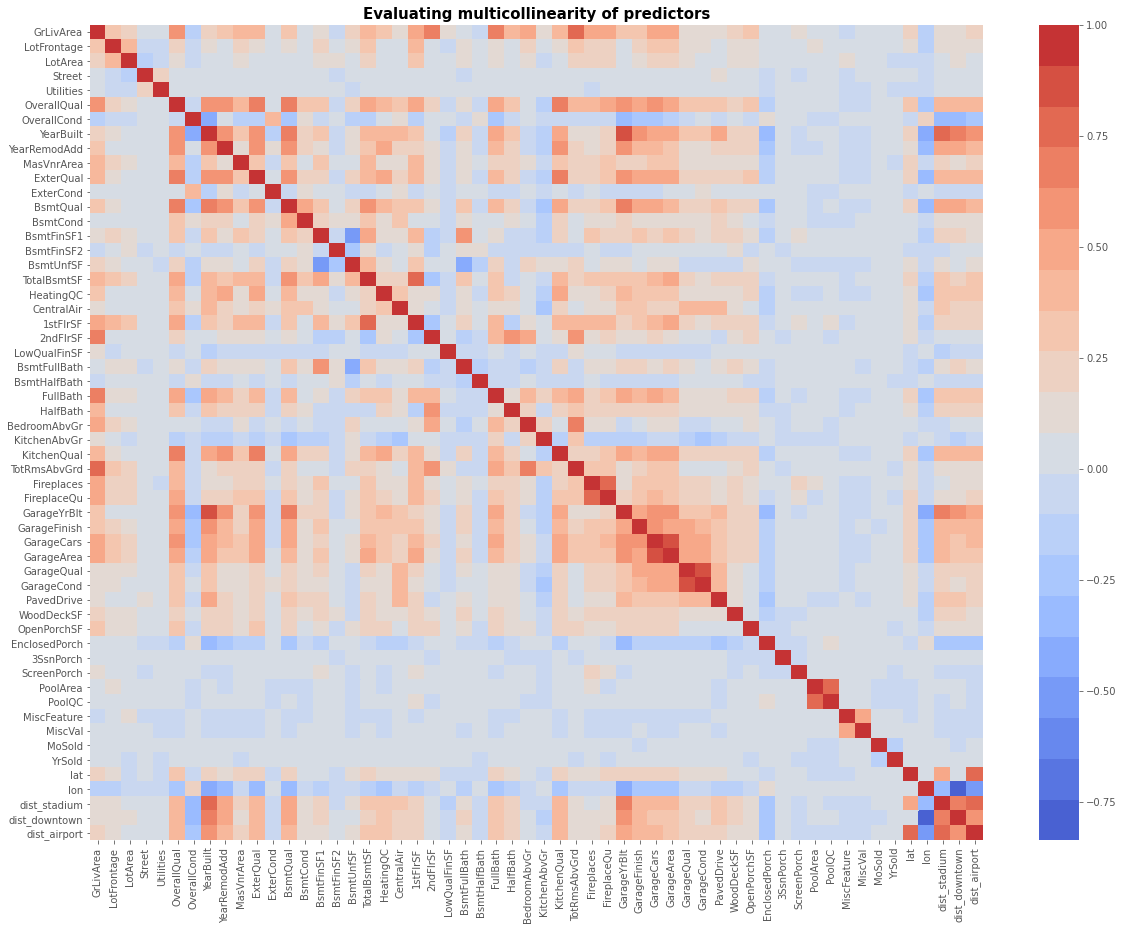

In [15]:
plt.figure(figsize = (20,15))
colormap = sns.color_palette('coolwarm',20)
sns.heatmap(numeric_features.corr(),cmap = colormap)
plt.title('Evaluating multicollinearity of predictors', fontsize= 15, fontweight = 'bold')

In [16]:
#Using original dataset to show correlations between price and each feature
r_prices = prices.corr()
r_prices = r_prices[['SalePrice']][1:]

Text(0.5, 1.0, 'Correlation between each feature and house price')

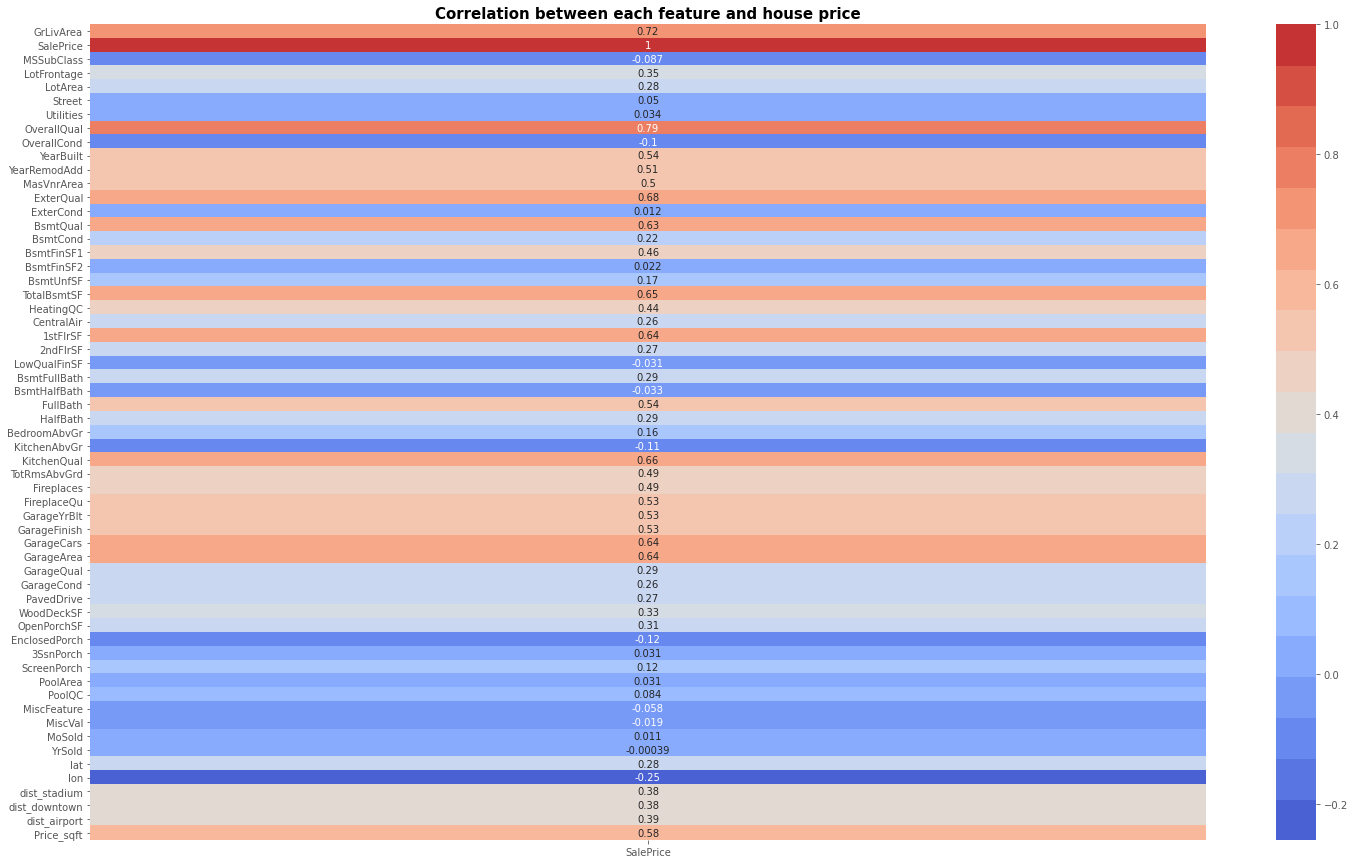

In [17]:
plt.figure(figsize = (25,15))
sns.heatmap(r_prices,annot = True,cmap = colormap)
plt.title('Correlation between each feature and house price', fontsize = 15, fontweight = 'bold')

In [18]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 0 to 2629
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2568 non-null   int64  
 1   LotFrontage    2568 non-null   float64
 2   LotArea        2568 non-null   int64  
 3   Street         2568 non-null   int64  
 4   Utilities      2568 non-null   int64  
 5   OverallQual    2568 non-null   int64  
 6   OverallCond    2568 non-null   int64  
 7   YearBuilt      2568 non-null   int64  
 8   YearRemodAdd   2568 non-null   int64  
 9   MasVnrArea     2568 non-null   float64
 10  ExterQual      2568 non-null   int64  
 11  ExterCond      2568 non-null   int64  
 12  BsmtQual       2568 non-null   int64  
 13  BsmtCond       2568 non-null   int64  
 14  BsmtFinSF1     2568 non-null   float64
 15  BsmtFinSF2     2568 non-null   float64
 16  BsmtUnfSF      2568 non-null   float64
 17  TotalBsmtSF    2568 non-null   float64
 18  HeatingQ

# Distribution of numerical variables

Median is $159,500.00
Mean is $177,941.81


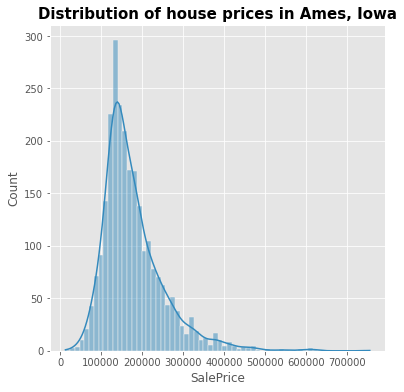

In [19]:
plt.figure(figsize = (6,6))
sns.histplot(prices.SalePrice,kde = True)
plt.title('Distribution of house prices in Ames, Iowa', fontsize = 15, fontweight = 'bold')
print('Median is ${:,.2f}'.format(np.median(prices.SalePrice)))
print('Mean is ${:,.2f}'.format(round(np.mean(prices.SalePrice),2)))

<Figure size 720x720 with 0 Axes>

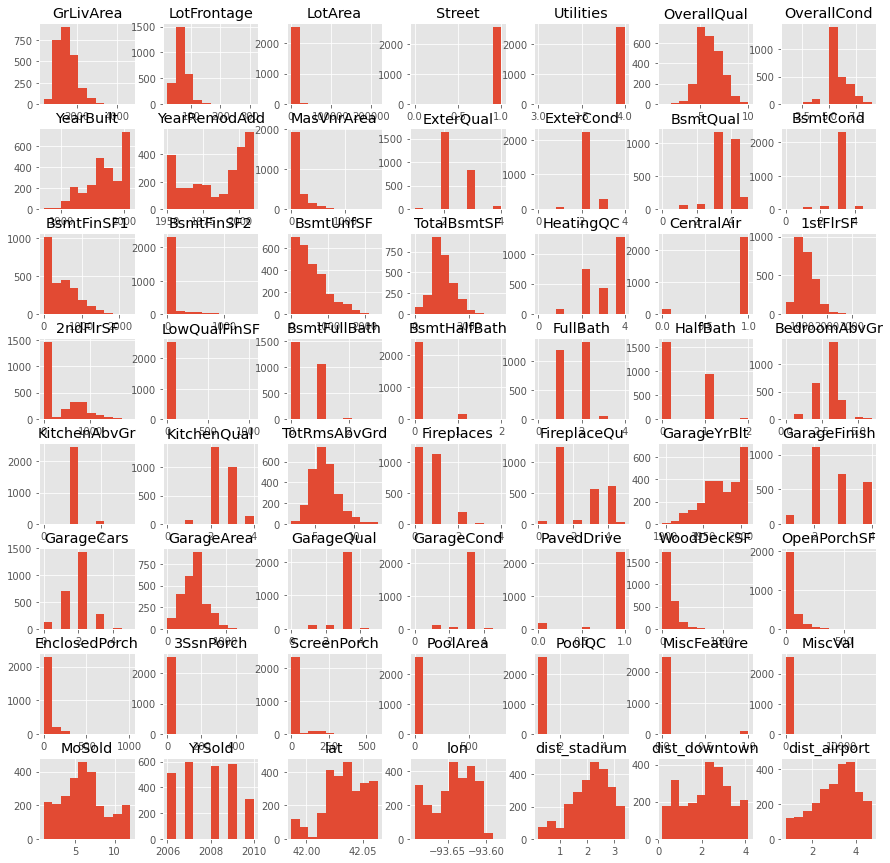

In [20]:
plt.figure(figsize = (10,10))
numeric_features.hist(figsize = (15,15))
plt.show()

# Feature Selection

#### Using five-fold CV to determine best hyperparameters for Lasso regression

In [21]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score



Xtrain,Xtest,ytrain,ytest = train_test_split(numeric_features,y_Logprice)

sc = StandardScaler()
cv = KFold(n_splits = 5, shuffle = True)


lasso = Lasso(max_iter = 3500000)
alphas = np.linspace(.00001,0.02,1000)

#manual grid search for ideal alpha
cv_res=[]

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    pipe = Pipeline(steps = [('sc',StandardScaler()),('lasso',lasso)])
    cv_res.append(cross_validate(pipe,Xtrain,ytrain,cv = cv, return_train_score = True))

In [22]:
lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]

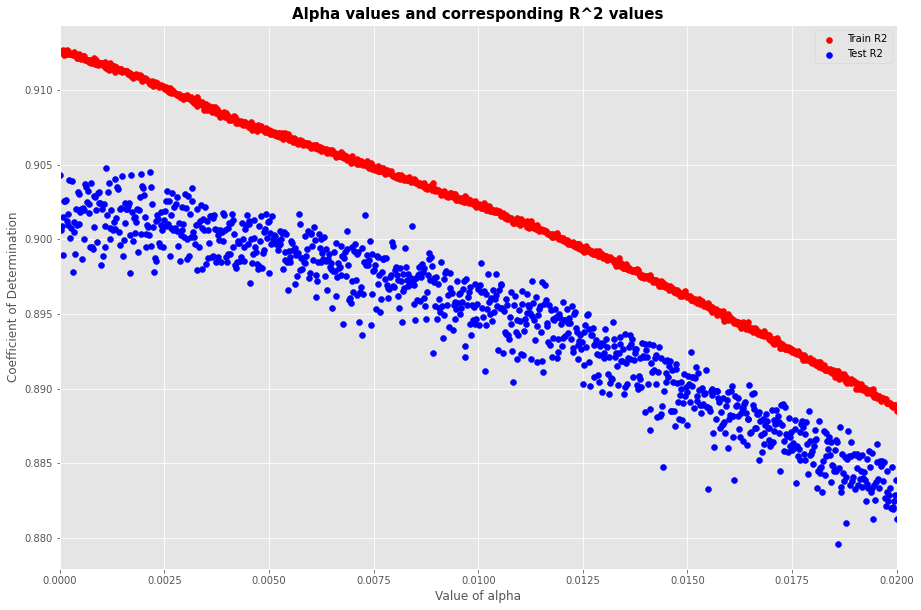

In [23]:
plt.figure(figsize = (15,10))
plt.scatter(alphas, lasso_train, c = 'red')
plt.scatter(alphas, lasso_test, c = 'blue')
plt.xlim([0,0.02])
plt.title(r'Alpha values and corresponding R^2 values',fontsize = 15, fontweight = 'bold')
plt.xlabel('Value of alpha')
plt.ylabel('Coefficient of Determination')
plt.legend(['Train R2', 'Test R2'])

In [24]:
alpha_ind = lasso_test.index(max(lasso_test))
f'alpha: {alphas[alpha_ind]}, train_score: {lasso_train[alpha_ind]}, test_score: {lasso_test[alpha_ind]}'

'alpha: 0.0011105505505505508, train_score: 0.911480637381854, test_score: 0.904800087662748'

In [25]:
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
lasso = Lasso()
lasso.set_params(alpha = alphas[alpha_ind])
lasso.fit(Xtrain,ytrain)

lasso_train_results = lasso.score(Xtrain,ytrain)
lasso_test_results = lasso.score(Xtest,ytest)
print(f'Lasso train score: {lasso_train_results}')
print(f'Lasso test score: {lasso_test_results}')

Lasso train score: 0.9107440449463391
Lasso test score: 0.8953924358067414


#### Test linear regression before removing columns

In [26]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtrain,ytrain)

print(f'Linear regression training score: {ols.score(Xtrain,ytrain)}')
print(f'Linear regression testing score: {ols.score(Xtest,ytest)}')

from sklearn.metrics import mean_squared_error
y_pred = ols.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.9117243266118582
Linear regression testing score: 0.8948022868721816
Linear regression RMSE: 0.13196858402670936


In [27]:
for col, coef in zip(numeric_features.columns,lasso.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   0.10182716883823545
LotFrontage:   0.018560994675752507
LotArea:   0.022555973630792942
Street:   0.006981053693338974
Utilities:   0.0030517088037961488
OverallQual:   0.0902293276872591
OverallCond:   0.04448933190783731
YearBuilt:   0.06112249345914991
YearRemodAdd:   0.012622120512735407
MasVnrArea:   -0.0020057472189044055
ExterQual:   0.00834905752028437
ExterCond:   2.475282176205715e-05
BsmtQual:   0.010726509776727445
BsmtCond:   0.0
BsmtFinSF1:   0.03327486856272693
BsmtFinSF2:   0.007365570176060343
BsmtUnfSF:   -0.0
TotalBsmtSF:   0.0340346818309678
HeatingQC:   0.019319957586545224
CentralAir:   0.01069843038121024
1stFlrSF:   0.010036150334190622
2ndFlrSF:   0.0
LowQualFinSF:   -0.006630548038689601
BsmtFullBath:   0.01062910740804077
BsmtHalfBath:   0.0009483027499941769
FullBath:   0.005226896564023157
HalfBath:   0.0
BedroomAbvGr:   -0.0015536082096530121
KitchenAbvGr:   -0.014968993102530923
KitchenQual:   0.014225543912808338
TotRmsAbvGrd:   0.0129174993

In [28]:
#Identify columns from Lasso regression that can be removed from model
coefs = lasso.coef_
zero_idx = np.where(coefs == 0)
numeric_features.columns[zero_idx]

Index(['BsmtCond', 'BsmtUnfSF', '2ndFlrSF', 'HalfBath', 'GarageQual',
       'OpenPorchSF', 'PoolArea', 'lon', 'dist_airport'],
      dtype='object')

# Drop Features Post-lasso

In [29]:
post_lasso = numeric_features.drop(numeric_features.columns[zero_idx],axis = 1)

In [30]:
Xtrain,Xtest,ytrain,ytest = train_test_split(post_lasso,y_Logprice)

Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)


ols2 = LinearRegression()
ols2.fit(Xtrain,ytrain)

LinearRegression()

In [31]:
print(f'Post-lasso training score: {ols2.score(Xtrain,ytrain)}')
print(f'Post-lasso testing score: {ols2.score(Xtest,ytest)}')

y_pred = ols2.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared=False)
print(f'Post-lasso RMSE: {RMSE}')

Post-lasso training score: 0.9112803668038961
Post-lasso testing score: 0.8927195957361462
Post-lasso RMSE: 0.12461255874732471


# Five-Fold cross-validation for OLS

In [32]:
ols_pipe = Pipeline(steps = [('ss',StandardScaler()),('ols',LinearRegression())])
cv_res2 =cross_validate(ols_pipe, Xtrain,ytrain ,cv = cv, return_train_score = True)

In [33]:
print(f"Testing score: {cv_res2['test_score'].mean()}")
print(f"Training score: {cv_res2['train_score'].mean()}")

neg_RMSE = cross_val_score(ols_pipe, Xtrain, ytrain, scoring = 'neg_root_mean_squared_error', cv = cv)


print(f'Cross-validated RMSE is: {np.mean(np.abs(neg_RMSE))}')

Testing score: 0.901375465236087
Training score: 0.9121864908014814
Cross-validated RMSE is: 3.2529646024508833e+25


<p>Linear regression runs into issues during 5-fold CV</p>

In [34]:
cv_res2

{'fit_time': array([0.0174253 , 0.01156783, 0.01272202, 0.01184583, 0.01489115]),
 'score_time': array([0.00070095, 0.00050306, 0.00050187, 0.0004952 , 0.00045991]),
 'test_score': array([0.92197082, 0.90287804, 0.90670839, 0.88261741, 0.89270267]),
 'train_score': array([0.90672848, 0.91219519, 0.9112509 , 0.91729055, 0.91346734])}

#### Assessing errors meet linear regression assumptions

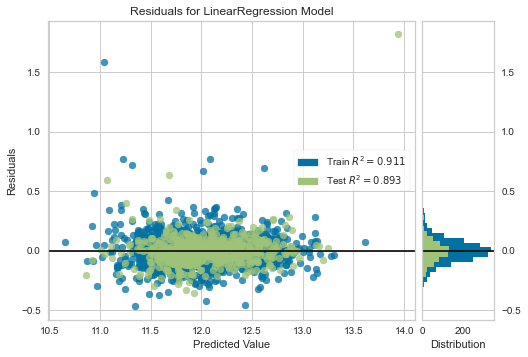

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
from yellowbrick.regressor import ResidualsPlot
ols2 = LinearRegression()
visualizer = ResidualsPlot(ols2)
visualizer.fit(Xtrain, ytrain) 
visualizer.score(Xtest, ytest)  
visualizer.show() 

## Regressing entire dataset to evaluate linear relationships between features and price

In [36]:
ols_described = LinearRegression()
Y = y_Logprice
X = sc.fit_transform(post_lasso)
ols_described.fit(X,Y)

LinearRegression()

Text(0.5, 1.0, 'Standardized betas in log(SalePrice) linear model')

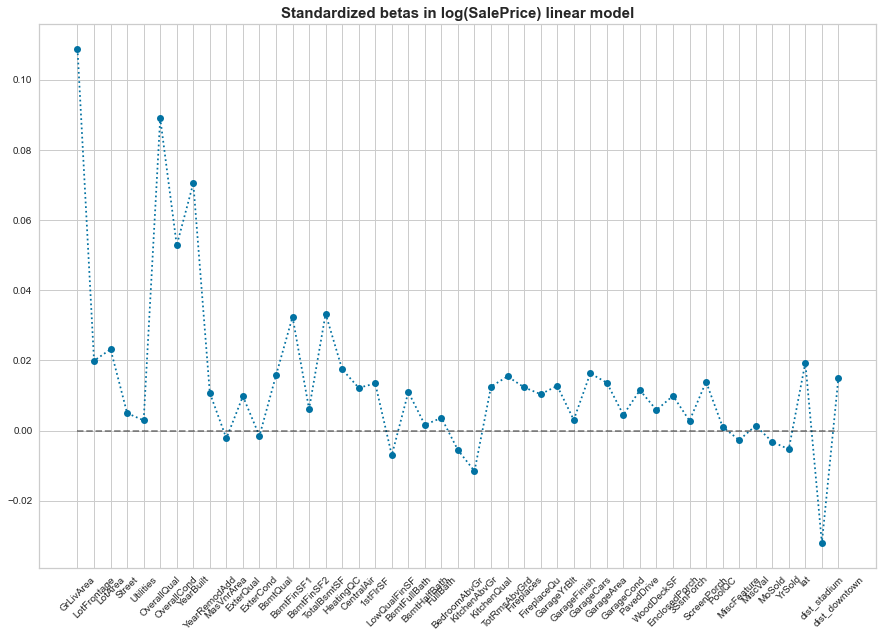

In [37]:
plt.figure(figsize = (15,10))
plt.plot(range(len(post_lasso.columns)),ols_described.coef_,'bo:')
plt.plot(range(len(post_lasso.columns)),np.array([0 for zero in range(len(post_lasso.columns))]),'k--',alpha = 0.49)
plt.xticks(range(len(post_lasso.columns)),labels = post_lasso.columns, rotation = 45)
plt.title('Standardized betas in log(SalePrice) linear model', fontsize = 15, fontweight = 'bold')

<p>Most influential features in the linear model are GrLivArea, OverallQual, OverallCond, and YearBuilt</p>

In [38]:
import statsmodels.api as sm
X = sm.add_constant(X)
OLS = sm.OLS(Y,X)
results = OLS.fit()

names = post_lasso.columns.tolist()
names.insert(0,'constant')
print(results.summary(xname = names))


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     529.7
Date:                Sun, 07 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:31:17   Log-Likelihood:                 1854.3
No. Observations:                2568   AIC:                            -3613.
Df Residuals:                    2520   BIC:                            -3332.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant         12.0126      0.002   5130.544

## Gradient Boosting

In [39]:
from sklearn.compose import ColumnTransformer

#Subclass is of numeric dtype, but are different house types
tree_prices['MSSubClass'] = tree_prices['MSSubClass'].astype(str)

tree_features = tree_prices.drop(['PID','SalePrice','Price_sqft'],axis = 1)

In [40]:
cat_cols = tree_features.select_dtypes(include = 'object').columns.tolist()
num_cols = tree_features.select_dtypes(exclude = 'object').columns.tolist()

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

ohe = OneHotEncoder(sparse = False,handle_unknown='ignore')

processing = ColumnTransformer(transformers = [('ohe',ohe, cat_cols),
                                               ('sc',StandardScaler(),num_cols)],remainder = 'passthrough')

Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)
tree_pipe = Pipeline(steps = [('process',processing),('gb',GradientBoostingRegressor())])
tree_pipe.fit(Xtrain,ytrain)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Ex...


In [42]:
print(tree_pipe.score(Xtrain,ytrain))
print(tree_pipe.score(Xtest,ytest))

y_pred = tree_pipe.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Gradient Boosting RMSE: {RMSE}')

0.9638901695260214
0.8993617440625574
Gradient Boosting RMSE: 0.12041012211061397


In [43]:
Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)
tree_cv =cross_validate(tree_pipe, Xtrain,ytrain,cv = cv, return_train_score = True)

In [44]:
tree_cv

{'fit_time': array([0.93924904, 0.94022608, 0.95521092, 0.9546051 , 0.95006299]),
 'score_time': array([0.00908804, 0.00900483, 0.00929403, 0.00929117, 0.00937295]),
 'test_score': array([0.9242545 , 0.92467138, 0.8858182 , 0.9234812 , 0.90915992]),
 'train_score': array([0.96533648, 0.96393264, 0.96583553, 0.96533115, 0.96546812])}

In [45]:
print(f"CV linear regression testing score: {cv_res2['test_score'].mean()}")
print(f"CV gradient boosted testing score: {np.mean(tree_cv['test_score'])}")

CV linear regression testing score: 0.901375465236087
CV gradient boosted testing score: 0.9134770407130638


<p>Gradient boosted model outperforms multiple linear regression.</p>

In [46]:
neg_RMSE = cross_val_score(tree_pipe, tree_features, y_Logprice, scoring = 'neg_root_mean_squared_error', cv = cv)
print(f'Cross-validated RMSE is: {np.mean(np.abs(neg_RMSE))}')

Cross-validated RMSE is: 0.11467748110246237


In [47]:
predicted_prices = np.exp(tree_pipe.predict(tree_features))

In [48]:
price_comp = pd.DataFrame({'Actual':tree_prices['SalePrice'],'Predicted':predicted_prices})

In [49]:
price_comp['Residuals'] = price_comp.Actual - price_comp.Predicted
price_comp['absResiduals'] = np.abs(price_comp['Residuals'])

In [50]:
price_comp.describe()

,Actual,Predicted,Residuals,absResiduals
count,2568.000000,2568.000000,2568.000000,2568.000000
mean,177941.813863,177037.018655,904.795208,10721.303048
std,75120.582411,72595.709628,18130.511224,14647.296440
min,12789.000000,17232.267617,-492007.899207,1.933143
25%,129900.000000,129888.917286,-6760.239587,3398.753320
50%,159500.000000,158917.876647,625.907674,7302.678969
75%,209500.000000,206857.149033,8039.290141,13746.628306
max,755000.000000,687140.917585,118078.016410,492007.899207


In [51]:
tree_prices['Predicted'] = price_comp.Predicted

In [52]:
tree_prices.head(10)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,lat,lon,dist_stadium,dist_downtown,dist_airport,Price_sqft,Predicted
0,909176150,856,126000,30,RL,58.769231,7890,Pave,DNE,Reg,...,2010,WD,Normal,42.018564,-93.651619,0.835068,1.997560,2.024702,147.196262,124822.885649
1,905476230,1049,139500,120,RL,42.000000,4235,Pave,DNE,Reg,...,2009,WD,Normal,42.024855,-93.663671,1.558185,2.566078,2.777751,132.983794,125681.919182
3,911128020,1001,124900,30,C (all),60.000000,6060,Pave,DNE,Reg,...,2007,WD,Normal,42.021548,-93.614068,1.173123,0.245745,1.616918,124.775225,117657.419948
4,535377150,1039,114000,70,RL,80.000000,8146,Pave,DNE,Reg,...,2009,WD,Normal,42.037391,-93.612207,1.897608,0.852123,2.704025,109.720885,101011.192370
5,534177230,1665,227000,60,RL,70.000000,8400,Pave,DNE,Reg,...,2009,WD,Normal,42.044554,-93.631818,1.966935,1.631256,3.184678,136.336336,217062.667862
6,908128060,1922,198500,85,RL,64.000000,7301,Pave,DNE,Reg,...,2009,ConLD,Normal,42.019009,-93.672987,1.928481,3.074472,2.950477,103.277836,209244.368208
7,902135020,936,93000,20,RM,60.000000,6000,Pave,Pave,Reg,...,2009,WD,Normal,42.031162,-93.612561,1.576285,0.423079,2.279611,99.358974,90767.592656
8,528228540,1246,187687,20,RL,53.000000,3710,Pave,DNE,Reg,...,2008,New,Partial,42.063284,-93.641569,3.263445,2.997337,4.548662,150.631621,174596.187643
9,923426010,889,137500,20,RL,74.000000,12395,Pave,DNE,Reg,...,2008,WD,Normal,41.986496,-93.603619,2.632937,2.715708,1.292634,154.668166,139039.473602
10,908186050,1072,140000,180,RM,35.000000,3675,Pave,DNE,Reg,...,2007,WD,Normal,42.018966,-93.669462,1.747762,2.895315,2.790099,130.597015,143888.460439


In [53]:
tree_prices['PriceBin'] = pd.qcut(tree_prices['SalePrice'],q=4,labels = ['Quart_1','Quart_2','Quart_3','Quart_4'])
tree_prices['Residuals'] = price_comp['Residuals']

Text(0, 0.5, 'Actual price - predicted price (USD)')

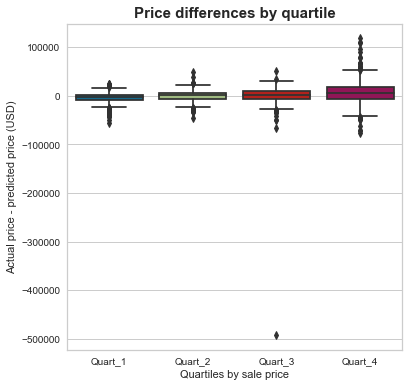

In [54]:
plt.figure(figsize = (6,6))
sns.boxplot(data = tree_prices, x = 'PriceBin', y = 'Residuals')
plt.title('Price differences by quartile',fontsize = 15, fontweight = 'bold')
plt.xlabel('Quartiles by sale price')
plt.ylabel('Actual price - predicted price (USD)')

<p>Gradient boosted model performs better on lower priced homes than more expensive ones.</p>